<a href="https://colab.research.google.com/github/huggoparcelly/rec-info/blob/main/Classificacao_de_Texto_(Huggo_Parcelly).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto

Implementação de modelos de classificação usando um [Dataset de notícias da BBC](https://www.kaggle.com/competitions/learn-ai-bbc/data).

Vamos classificar as notícias em 'business', 'entertainment', 'politics', 'sport' ou 'tech'.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Carga dos Dados
(CSV armazenado no drive)

In [ ]:
!wget -O bbc_news.csv "https://docs.google.com/uc?export=download&id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7"

# Lê o dataframe
df = pd.read_csv('./bbc_news.csv', encoding= 'unicode_escape')

--2024-04-16 18:42:51--  https://docs.google.com/uc?export=download&id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7
Resolving docs.google.com (docs.google.com)... 64.233.183.102, 64.233.183.100, 64.233.183.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.183.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7&export=download [following]
--2024-04-16 18:42:51--  https://drive.usercontent.google.com/download?id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.234.132, 2607:f8b0:4001:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.234.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5108614 (4.9M) [application/octet-stream]
Saving to: ‘bbc_news.csv’

bbc_news.csv        100%[===================>]   4.87M  --.-KB/s    in 

### Inspeção do Dataset

In [ ]:
# Descreve o dataset
print('SHAPE OF DATASET: ', df.shape,
      '\n\nCOLUMNS IN DATASET: ', df.columns,
      '\n\nCATEGORIES: ', df.category.unique(),
      '\n\nDATA SAMPLE: \n\n', df.sample(n=5), '\n\n')

SHAPE OF DATASET:  (2225, 2) 

COLUMNS IN DATASET:  Index(['text', 'category'], dtype='object') 

CATEGORIES:  ['business' 'entertainment' 'politics' 'sport' 'tech'] 

DATA SAMPLE: 

                                                    text       category
1042  Chancellor rallies Labour voters\n \n Gordon B...       politics
568   Children vote Shrek 2 best film\n \n Young UK ...  entertainment
378   Ask Jeeves tips online ad revival\n \n Ask Jee...       business
809   Neeson in bid to revive theatre\n \n Hollywood...  entertainment
163   Criminal probe on Citigroup deals\n \n Traders...       business 




NUMBER OF SAMPLES IN EACH CATEGORY: 

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


<Axes: >

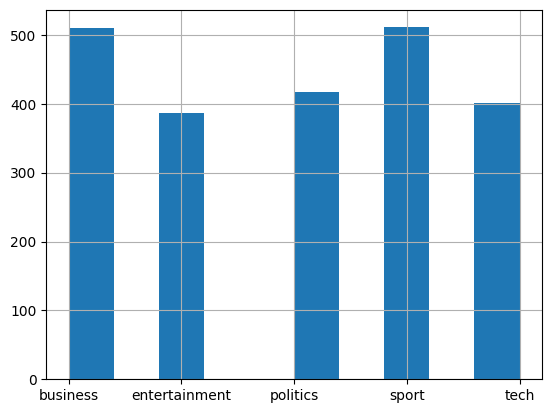

In [ ]:
# Verifica a quantidade de itens por classe
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
print(df.category.value_counts())
df.category.hist()

## Pré processamento dos dados

In [ ]:
# Limpeza dos dados
print('Data cleaning in progress...')

# Tokenização
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remoção de stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remoção números, pontuação e caracters especiais
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lematização
# Execução simplificada sem o uso do POS-Tagger
# TODO OPCIONAL: adicione o POS-Tagger
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item) for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



In [ ]:
print('Before Cleaning:\n\n', df['text'][0:5])
df['text'] = df['text_clean'].apply(lambda x: ' '.join(x))
print('After Cleaning:\n\n', df['text'][0:5])

Before Cleaning:

 0    China had role in Yukos split-up\n \n China le...
1    Oil rebounds from weather effect\n \n Oil pric...
2    Indonesia 'declines debt freeze'\n \n Indonesi...
3    $1m payoff for former Shell boss\n \n Shell is...
4    US bank in $515m SEC settlement\n \n Five Bank...
Name: text, dtype: object
After Cleaning:

 0    role split-up lent help government renationali...
1    rebound weather effect price recovered trade f...
2    debt freeze' longer need debt freeze offered g...
3    payoff former bos pay ex-finance chief stepped...
4    bank settlement subsidiary agreed pay total se...
Name: text, dtype: object


## Preparação dos dados para treino / teste

### Codificação das Labels

Transforma as labels ('business', 'entertainment', 'politics', 'sport', 'tech') em números (0,1,2,3,4)

In [ ]:
# Transformando as labels com LabelEncoder
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

In [ ]:
# Verificando as labels originais (ficam armazenadas como atributo do encoder)
labels

['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
# Checando o novo conteúdo do dataframe (apenas para uma parte dele)
df['category'][600:655]

600    1
601    1
602    1
603    1
604    1
605    1
606    1
607    1
608    1
609    1
610    1
611    1
612    1
613    1
614    1
615    1
616    1
617    1
618    1
619    1
620    1
621    1
622    1
623    1
624    1
625    1
626    1
627    1
628    1
629    1
630    1
631    1
632    1
633    1
634    1
635    1
636    1
637    1
638    1
639    1
640    1
641    1
642    1
643    1
644    1
645    1
646    1
647    1
648    1
649    1
650    1
651    1
652    1
653    1
654    1
Name: category, dtype: int64

Gera Word Clouds / Nuvens de palavras
(apenas para ter um insight do conteúdo textual em cada classe)

Business words:


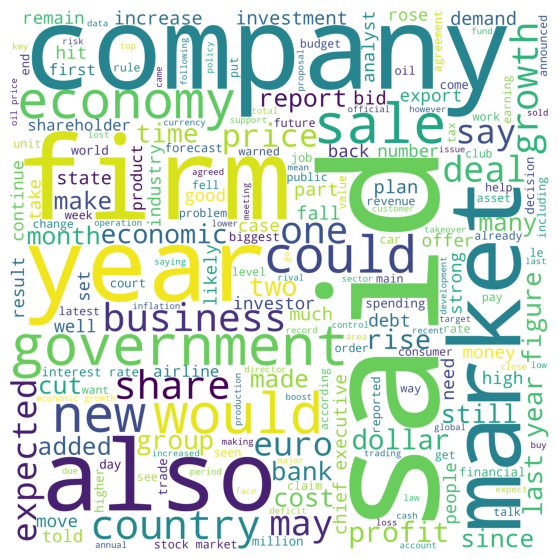

Entertainment words:


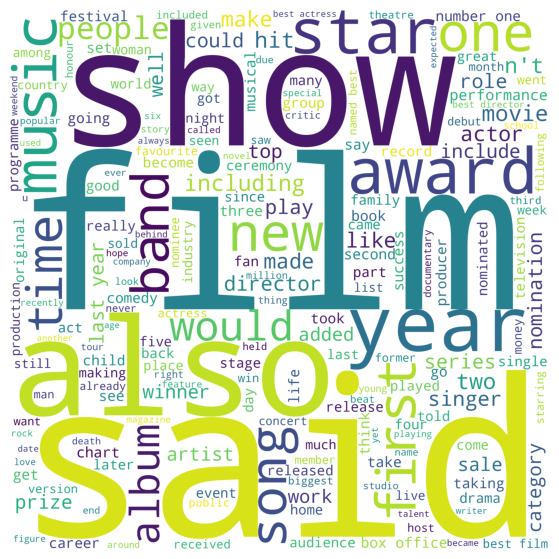

Politics words:


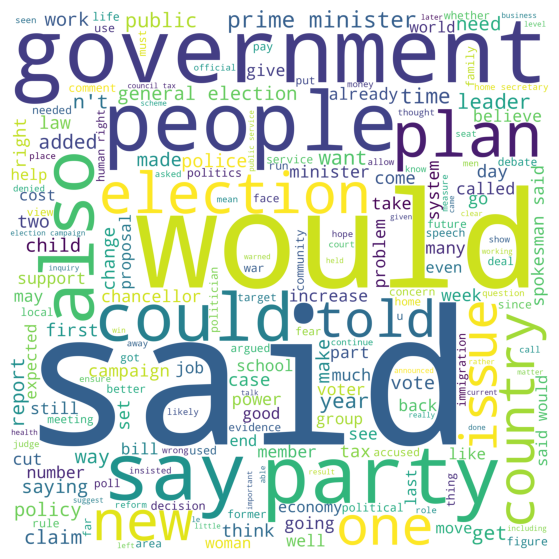

Sport words:


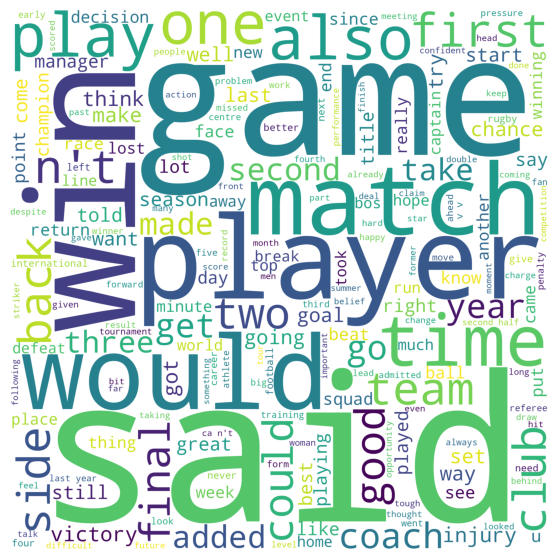

Tech words:


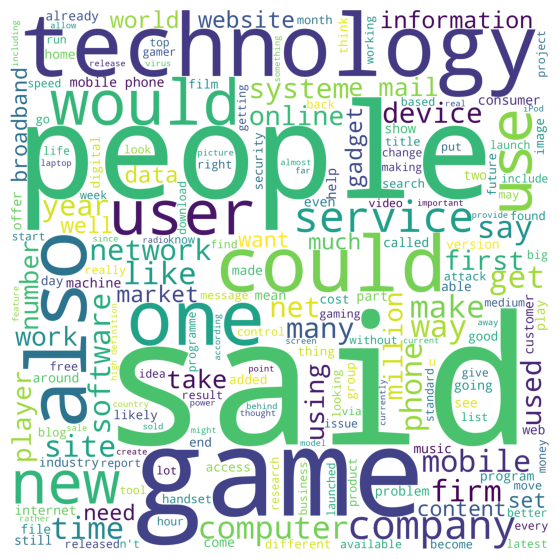

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

business = df[df['category'] == 0]
business = business['text']

entertainment = df[df['category'] == 1]
entertainment = entertainment['text']

politics = df[df['category'] == 2]
politics = politics['text']

sport = df[df['category'] == 3]
sport = sport['text']

tech = df[df['category'] == 4]
tech = tech['text']

def wordcloud_draw(df, color = 'white'):

  words = ' '.join(df)
  cleaned_word = ' '.join([word for word in words.split() if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop, background_color = color, width = 2500, height = 2500).generate(cleaned_word)

  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("Business words:")
wordcloud_draw(business, 'white')

print("Entertainment words:")
wordcloud_draw(entertainment, 'white')

print("Politics words:")
wordcloud_draw(politics, 'white')

print("Sport words:")
wordcloud_draw(sport, 'white')

print("Tech words:")
wordcloud_draw(tech, 'white')


### Separação dos dados para treino / teste

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

In [ ]:
# Verificando uma porção dos dados de treino (parte X, onde estão os valores das features)
X_train[0:5]

612     film disaster' expert told child abuse trial d...
946     social sciences' national body designed tackle...
959     tout replacement plan group tried raise pressu...
725     retains number one spot charity single held ch...
2146    offer retro fun drill sergeant past wake-up ca...
Name: text, dtype: object

In [ ]:
# Verificando uma porção dos dados de treino (parte Y, onde estão os valores das labels)
y_train[0:5]

612     1
946     2
959     2
725     1
2146    4
Name: category, dtype: int64

### Vetorização com TF-IDF

Precisamos transformar nossos dados de treino em uma tabela (dataframe) com features. Uma abordagem simples seria fazer cada coluna como um palavra e os valores seriam 0 ou 1. Para melhorar essa abordagem totalmente booleana, poderíamos contar as ocorrências e usar essa quantidade como valor das features, o que já proporcionaria um resultado mais interessante. Porém, palavras muito comuns teriam uma importância muito grande para definir a classe.

Então, para melhorar ainda mais, podemos fazer com que os valores das células sejam estatísticas de TF-IDF. Assim, encontramos um equilíbrio entre quantidade de ocorrências no documento e a raridade da palavra no dataset. Neste caso, valores maiores de TF-IDF indicam que as palavras são mais relevantes para classificar um documento.

In [ ]:
vec = TfidfVectorizer()
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

Observe que transformamos tanto os dados de treino quanto os de teste, pois, para avaliar o modelo produzido, os dados de teste devem ter a mesma representação dos dados de treino. Afinal, o modelo vai identificar os padrões nos dados representados daquela forma!

## Treinando um Modelo com Algoritmo Multinomial Naive Bayes

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier

# Import da classe que implementa o algoritmo que vamos usar para fazer o treinamento
from sklearn.naive_bayes import MultinomialNB

# Aqui basta instanciar o objeto (sem passar parâmetros)
model = MultinomialNB()

# Aqui você vai executar o treinamento invocando o método fit (já está abaixo)
# Falta apenas especificar os dados de treinamento (são dois parâmetros, um para os dados X e ou para os dados y)
# Verifique a documentação em https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# TODO model.fit(...)
model.fit(X_train_vec, y_train)

MultinomialNB()

Cuidado, você precisa especificar os dados X em formato TF-IDF, ou seja, após a transformação que fizemos! Caso tenha especificado os dados originais (gerados logo após o split), mude seu código acima!

# Fazendo predições com o modelo gerado

Simples assim! Já temos nosso modelos de classificação. Agora é só se divertir fazendo inferências.

In [ ]:
# Visualizando 01 (UM) item no conjunto de teste ANTES da transformação para TF-IDF
# Faremos nossa primeira predição com essa notícia! Você já tem um palpite?
print(X_test[0:1], '\n\n\n')

1199    plan criticised environmental damage caused go...
Name: text, dtype: object 





In [ ]:
# Visualizando o mesmo item no conjunto de teste, só que APÓS a transformação para TF-IDF
# Ou seja, essa é a representação de uma única notícia, porém, em formato de vetor, onde cada elemento do vetor
# corresponde a uma feature que definimos (uma palavra).
print(X_test_vec[0:1])


  (0, 14380)	0.07459629390426274
  (0, 14350)	0.019468125001108467
  (0, 14305)	0.021247586393653855
  (0, 14280)	0.042725963307939326
  (0, 14237)	0.08589340414591398
  (0, 14034)	0.068527182486944
  (0, 14012)	0.04503656541114189
  (0, 13690)	0.0406419711869731
  (0, 13657)	0.09537881004247839
  (0, 13437)	0.06749359874250749
  (0, 13151)	0.13815350134524038
  (0, 12958)	0.08642826752396693
  (0, 12872)	0.04807159275511703
  (0, 12859)	0.061930940601679314
  (0, 12856)	0.038902182229042064
  (0, 12640)	0.043632504111766696
  (0, 12529)	0.14752582844276702
  (0, 12458)	0.06402953182347107
  (0, 12453)	0.1803786244623262
  (0, 12364)	0.04575413352576178
  (0, 12278)	0.04317127996489596
  (0, 12063)	0.05145947713280032
  (0, 12062)	0.04796169504237882
  (0, 12059)	0.08443773470100033
  (0, 11950)	0.059310385106571335
  :	:
  (0, 2577)	0.056695208867239826
  (0, 2573)	0.058793800089031574
  (0, 2469)	0.08878256815721369
  (0, 2394)	0.06329145075250452
  (0, 2346)	0.16042183472551289
  (0

In [ ]:
# Executa a classificação e imprime a classe inferida
# Observe que a saída é no formato de lista. Isso acontece porque há problemas em ML queremos atribuir mais de um rótulo
# ao mesmo tempo (classificações multilabel). Por exemplo: um filme pode ser comédia e romance ao mesmo tempo. Mas nosso problema
# aqui é de outra natureza, então só estamos interessados no primeiro (e único) elemento da lista.
p = model.predict(X_test_vec[0])
print(p)

[2]


In [ ]:
# imprimindo o rótulo amigável
# TODO seu código aqui
label = ['business', 'entertainment', 'politics','sport', 'tech']

p = model.predict(X_test_vec[0:1])
cod_numerico = p[0]
print(label[cod_numerico])

politics


Vamos verificar se acertamos!!

(imprima o gabarito)

In [ ]:
# Imprimir o código númerico da classe
# TODO seu código aqui
print(y_test.iloc[0])

2


In [ ]:
# Imprimir o rótulo da classe em formato amigável
# TODO seu código aqui
cod_numerico_y = y_test.iloc[0]
print(label[cod_numerico_y])

politics


### Vamos criar nossos próprios textos e fazer inferências!

In [ ]:
# Definição da função que recebe um texto qualquer e executa a classificação
# Nada a ser feito aqui
def classify_text(vectorizer, classifier, input_text):
  y_pred1 = vectorizer.transform([input_text])
  yy = classifier.predict(y_pred1)
  result = ""
  if yy == [0]:
    result = "Business News"
  elif yy == [1]:
    result = "Entertainment News"
  elif yy == [2]:
    result = "Politics News"
  elif yy == [3]:
    result = "Sports News"
  elif yy == [4]:
    result = "Tech News"
  return result

In [ ]:
# TODO mostre 3 (três) exemplos com pequenos textos criados por você.
# Eles podem ser realmente pequenos (por exemplo, <15 palavras).
# Imprima os resultados

# TODO seu código aqui

# Primeiro texto sobre tecnologia
text_1 = "New AI breakthrough revolutionizes healthcare diagnostics, improving accuracy and efficiency."
# Segundo texto sobre esportes
text_2 = "Soccer star Ronaldo scores hat-trick, leading team to victory in thrilling match."
# Terceiro texto sobre entretenimento
text_3 = "Highly anticipated movie sequel breaks box office records, delighting fans worldwide."


classify_text1 = classify_text(vec, model, text_1)
print(classify_text1)
classify_text2 = classify_text(vec, model, text_2)
print(classify_text2)
classify_text3 = classify_text(vec, model, text_3)
print(classify_text3)

Business News
Sports News
Entertainment News


## Avaliação do Modelo

### Precision, Recall, F1

In [ ]:
# Calcula e imprime as métricas de Precision, Recall e F1
# Nada a fazer aqui
y_pred = model.predict(X_test_vec)
print("Precision: %1.3f" % (precision_score(y_test, y_pred, average='macro')))
print("Recall: %1.3f" % (recall_score(y_test, y_pred, average='macro')))
print("F1: %1.3f\n" % (f1_score(y_test, y_pred, average='macro')))

Precision: 0.955
Recall: 0.947
F1: 0.950

